<a href="https://colab.research.google.com/github/ranveersingh81/scanpath/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import os
# import scanpath as scp
import math
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import pickle
from scanpath import plotting
import numpy as np

In [18]:
from google.colab import drive
drive.mount('/content/drive/')
! cp -r /content/drive/MyDrive/scanpath_data /content/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
! sudo rm -rv /content/scanpath
! git clone https://github.com/ranveersingh81/scanpath.git


removed '/content/scanpath/scanpath_analysis.py'
removed '/content/scanpath/__pycache__/scanpath.cpython-310.pyc'
removed directory '/content/scanpath/__pycache__'
removed '/content/scanpath/.git/HEAD'
removed directory '/content/scanpath/.git/branches'
removed '/content/scanpath/.git/objects/pack/pack-87749871b23ffa3de53554cd0085e9e115a7ff7c.idx'
removed '/content/scanpath/.git/objects/pack/pack-87749871b23ffa3de53554cd0085e9e115a7ff7c.pack'
removed directory '/content/scanpath/.git/objects/pack'
removed directory '/content/scanpath/.git/objects/info'
removed directory '/content/scanpath/.git/objects'
removed '/content/scanpath/.git/info/exclude'
removed directory '/content/scanpath/.git/info'
removed '/content/scanpath/.git/packed-refs'
removed directory '/content/scanpath/.git/refs/tags'
removed '/content/scanpath/.git/refs/heads/main'
removed directory '/content/scanpath/.git/refs/heads'
removed '/content/scanpath/.git/refs/remotes/origin/HEAD'
removed directory '/content/scanpath/

In [20]:
def get_file_data(file):
    file_path = os.path.join('/content/scanpath_data/scanpaths/', file)
    df = pd.read_csv(file_path, delimiter='\t')
    cols = df.columns.to_list()
    df['file'] = file.replace("_scanpath.tsv", "")
    df = df[['file'] + cols]
    return df
files = [i for i in os.listdir('/content/scanpath_data/scanpaths/')]
master_df = get_file_data(files[0])

for i  in  files[1:]:
    master_df = pd.concat([master_df, get_file_data(i)])

reader_data = pd.read_csv("/content/scanpath_data/reader_meta_mean_and_per-text.csv")

def get_scanpath(scan_record):
    scanpath = master_df[master_df['file'] == scan_record]
    scanpath = scanpath[['fixation_index', 'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'line', 'char_index_in_line',
                    'fixation_position_x', 'fixation_position_y', 'word_index_in_text', 'sent_index_in_text', 'char_index_in_text']]
    scanpath['change_in_word_flag'] = (scanpath['word_index_in_text'].diff() == 0).astype(int).shift(-1)
    scanpath['change_in_word'] = (scanpath['change_in_word_flag'] == 0).cumsum().shift(1).fillna(0)
    scanpath['same_word_next_saccade_duration'] = scanpath['change_in_word_flag']*scanpath['next_saccade_duration']
    scanpath['next_saccade_duration'] = scanpath['next_saccade_duration'] - scanpath['same_word_next_saccade_duration']
    scanpath['fixation_duration'] = scanpath['same_word_next_saccade_duration'] + scanpath['fixation_duration']
    scanpath = scanpath.drop('same_word_next_saccade_duration', axis =1)
    scanpath = scanpath.groupby(['change_in_word', 'word_index_in_text']).aggregate({'fixation_duration':'sum', 'next_saccade_duration':'sum', 'fixation_position_x':'mean', 'fixation_position_y':'mean'}).reset_index()
    scanpath['cum_fixation_duration'] = scanpath['fixation_duration'].cumsum().shift(1).fillna(0)
    scanpath = scanpath.reset_index()
    return scanpath

all_columns = ['file', 'fixation_index', 'text_domain', 'trial', 'acc_bq_1', 'acc_bq_2', 'acc_bq_3', 'acc_tq_1', 'acc_tq_2', 'acc_tq_3',
'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'version', 'line', 'roi', 'char_index_in_line',
'original_fixation_index', 'is_fixation_adjusted', 'reader_id', 'text_id', 'fixation_position_x', 'fixation_position_y',
'word_index_in_text', 'sent_index_in_text', 'char_index_in_text', 'word', 'character', 'text_id_numeric']

In [22]:
files = [i for i in files if "p0" in i]

NameError: name 'np' is not defined

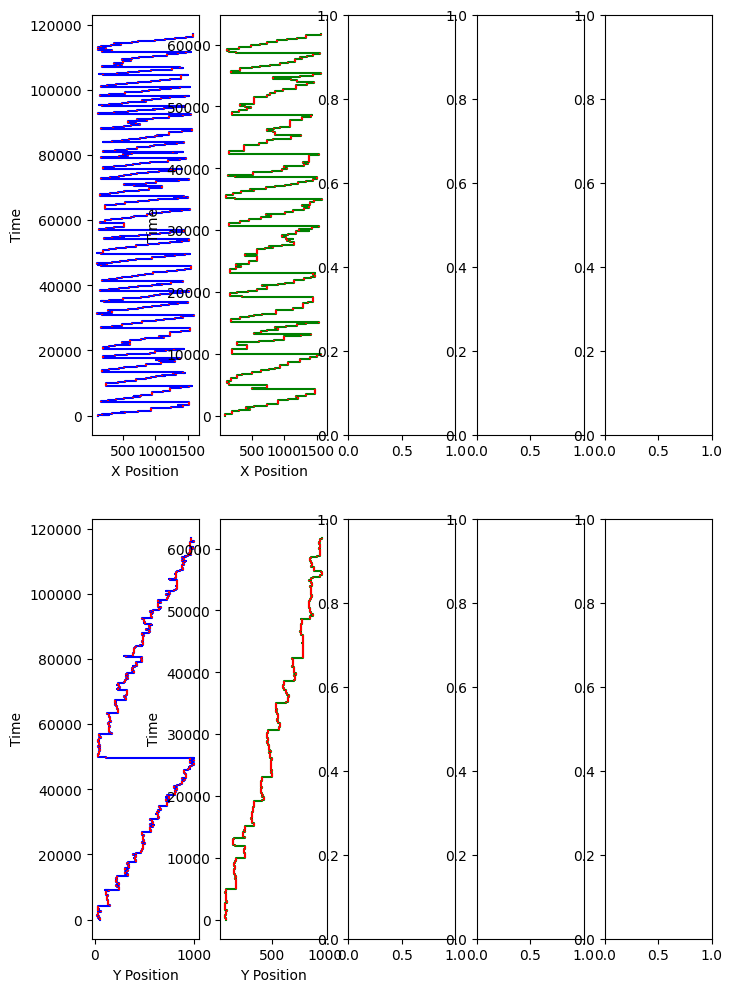

In [40]:
comparison_folder = "/content/scanpath_data/scanpath_comparisons"

comparisons = os.listdir(comparison_folder)

for comp in comparisons[:1]:
    with open(os.path.join(comparison_folder, comp), 'rb') as handle:
        data = pickle.load(handle)
        file1 = comp.split("_")[0] + "_" + "p0"
        file2 = comp.split("_")[2] + "_" + "p0"
        comp_ = comp.replace(".pickle" , "")
        score, path, alignment, path_df = data[comp_]
        scanpath1 = get_scanpath(file1)
        scanpath2 = get_scanpath(file2)
        alignment = alignment.merge(scanpath1[['index', 'fixation_position_x', 'fixation_position_y', 'fixation_duration', 'cum_fixation_duration']], left_on='s', right_on='index', how='left').rename(columns={'fixation_position_x':'fixation_position_x_s', 'fixation_position_y':'fixation_position_y_s',                                                                                                                                                                                         'fixation_duration':'fixation_duration_s', 'cum_fixation_duration':'cum_fixation_duration_s'}).drop('index', axis=1)
        alignment = alignment.merge(scanpath2[['index', 'fixation_position_x', 'fixation_position_y', 'fixation_duration', 'cum_fixation_duration']], left_on='t', right_on='index', how='left').rename(columns={'fixation_position_x':'fixation_position_x_t', 'fixation_position_y':'fixation_position_y_t',
                                                                                                                                                                                                                'fixation_duration':'fixation_duration_t', 'cum_fixation_duration':'cum_fixation_duration_t'}).drop('index', axis=1)
        fig, axs = plt.subplots(2, 5, figsize=(8, 12))
        axs = plotting.plot_scanpaths(axs, [scanpath1, scanpath2])
        axs = plotting.plot_alignments(axs, alignment)

        for ax in axs:
            for axx in ax:
                axx.tick_params(axis='x', rotation=90)

        plt.tight_layout()
        plt.pause(1)

In [ ]:
simmilarity_matrix_df = pd.DataFrame(data = simmilarity_matrix, columns=files, index=files)
simmilarity_matrix_df = simmilarity_matrix_df.iloc[:43, :43]
files_cluster = [files[i] for i in range(file_count)][:43]
simmilarity_matrix_np = simmilarity_matrix_df.to_numpy()
from sklearn.cluster import KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit_predict(simmilarity_matrix_np)
cluster_labels = kmeans.labels_.tolist()
print("Cluster Labels:", cluster_labels)
cluster_df = pd.DataFrame(data=list(zip(files_cluster, cluster_labels)), columns=['file','cluster'])
cluster_df['readerID'] = cluster_df['file'].apply(lambda x: int(x.split("_")[0].replace("reader", "")))
reader_data_ = reader_data[['readerID', 'expert', 'meanPhyAccTQ', 'meanPhyAccBQ']]
df = cluster_df.merge(reader_data_, on="readerID").sort_values(by='cluster')
# df = df.groupby(["cluster", "expert"]).agg({"expert":"count"}).add_suffix("_count").reset_index()
# ll = cluster_df[cluster_df['cluster']==0]['file'].tolist()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(simmilarity_matrix_df)